In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm
import time

from sklearn.preprocessing import StandardScaler    # RobustScaler
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
from scipy.stats import pearsonr

import warnings
import lightgbm as lgb
warnings.simplefilter("ignore")
pd.set_option("display.max_columns", None)

cut_type = 'peryear'
train_type = 'scilearn'
data_type = 'all'


begin_test_date = '2021-06-13  00:00:00'
end_test_date = '2021-09-21  00:00:00'
train_instant = True
modelpath = './catM'



## Load Data

In [2]:
df_asset_details = pd.read_csv(r"../input/g-research-crypto-forecasting/asset_details.csv").sort_values("Asset_ID")
df_asset_details

,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin
3,5,1.386294,EOS.IO
5,6,5.894403,Ethereum
4,7,2.079442,Ethereum Classic
11,8,1.098612,IOTA
6,9,2.397895,Litecoin


In [3]:
df = pd.read_csv("../input/g-research-crypto-forecasting/train.csv")
df_sup = pd.read_csv("../input/g-research-crypto-forecasting/supplemental_train.csv")
df_sup = df_sup[df_sup.timestamp>df.timestamp.max()]
df = pd.concat([df,df_sup]).reset_index(drop=True)
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")


In [4]:
df = df.replace([np.inf, -np.inf], np.nan)

In [5]:
df = df.sort_values(by='datetime').reset_index(drop=True)

In [6]:
df['Close_now_15'] = df.groupby('Asset_ID')['Close'].shift(15)/df['Close']
df['Close_now_30'] = df.groupby('Asset_ID')['Close'].shift(30)/df['Close']
df['Close_now_60'] = df.groupby('Asset_ID')['Close'].shift(60)/df['Close']
df['Close_now_90'] = df.groupby('Asset_ID')['Close'].shift(90)/df['Close']
df['Close_now_150'] = df.groupby('Asset_ID')['Close'].shift(150)/df['Close']
df['Close_now_600'] = df.groupby('Asset_ID')['Close'].shift(600)/df['Close']
df['Close_now_1500'] = df.groupby('Asset_ID')['Close'].shift(1500)/df['Close'] 


In [7]:
df['Volume_now_15'] = df.groupby('Asset_ID')['Volume'].shift(15)/df['Volume']
df['Volume_now_30'] = df.groupby('Asset_ID')['Volume'].shift(30)/df['Volume']
df['Volume_now_60'] = df.groupby('Asset_ID')['Volume'].shift(60)/df['Volume']
df['Volume_now_90'] = df.groupby('Asset_ID')['Volume'].shift(90)/df['Volume']
df['Volume_now_150'] = df.groupby('Asset_ID')['Volume'].shift(150)/df['Volume']
df['Volume_now_600'] = df.groupby('Asset_ID')['Volume'].shift(600)/df['Volume']
df['Volume_now_1500'] = df.groupby('Asset_ID')['Volume'].shift(1500)/df['Volume'] ##


In [8]:
df.shape

(26755084, 25)

In [9]:
def get_weighted_asset_feature(df, col):
    df['w'] = df['Asset_ID'].map(df_asset_details.set_index(keys='Asset_ID')['Weight'])
    weight_sum = df_asset_details.Weight.sum()

    df['W_'+col] = df.w * df[col]
    time_group = df.groupby('datetime')

    m = time_group['W_'+col].sum() / time_group['w'].sum()
    #m = time_group['weighted_asset_r'].sum() / weight_sum

    df.set_index(keys=['datetime'], inplace=True)
    df['W_'+col] = m
    df.reset_index(inplace=True)
    return df



In [10]:
df = get_weighted_asset_feature(df, 'Close_now_15') 


In [11]:
df.head()

,datetime,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Close_now_15,Close_now_30,Close_now_60,Close_now_90,Close_now_150,Close_now_600,Close_now_1500,Volume_now_15,Volume_now_30,Volume_now_60,Volume_now_90,Volume_now_150,Volume_now_600,Volume_now_1500,w,W_Close_now_15
0,2018-01-01 00:01:00,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.397895,0.0
1,2018-01-01 00:01:00,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.304065,0.0
2,2018-01-01 00:01:00,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.779922,0.0
3,2018-01-01 00:01:00,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.386294,0.0
4,2018-01-01 00:01:00,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.079442,0.0


In [12]:
df_train = df[df["datetime"] >= "2018-01-01 00:00:00"].reset_index(drop=True) 

df_test = df[(df["datetime"] >= begin_test_date)&(df["datetime"] <= end_test_date)].reset_index(drop=True)
print('test shape:',df_test.shape)



test shape: (2015112, 27)


In [13]:
import gc
del df
gc.collect()

30

In [14]:
df_test.head()

,datetime,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Close_now_15,Close_now_30,Close_now_60,Close_now_90,Close_now_150,Close_now_600,Close_now_1500,Volume_now_15,Volume_now_30,Volume_now_60,Volume_now_90,Volume_now_150,Volume_now_600,Volume_now_1500,w,W_Close_now_15
0,2021-06-13,1623542400,8,35.0,1.003150,1.019800,0.987300,1.003300,7.061928e+03,1.002936,-0.005097,1.024718,1.012210,1.009818,0.999153,1.011063,1.027908,1.029204,0.190468,1.539509,0.537947,0.199582,0.205974,3.522069,0.147088,1.098612,1.003868
1,2021-06-13,1623542400,12,383.0,0.327973,0.329272,0.327650,0.328829,5.364911e+05,0.328582,-0.003314,1.000986,1.011739,1.019813,1.015622,1.023057,0.994563,0.970184,0.084760,0.245798,0.307601,0.156118,0.820148,0.243187,1.552891,2.079442,1.003868
2,2021-06-13,1623542400,13,229.0,0.068132,0.068240,0.068038,0.068158,3.046438e+06,0.068158,-0.003036,1.003507,1.004274,1.002714,1.001605,1.009654,1.006291,1.014655,0.391491,0.400663,0.275337,0.344468,0.167740,0.133044,2.335231,1.791759,1.003868
3,2021-06-13,1623542400,10,61.0,2939.862750,2952.160000,2936.230000,2947.078025,9.584785e+00,2945.110614,-0.004899,1.002854,1.003063,1.003949,1.002121,1.017494,1.018638,0.991376,0.002335,0.260399,0.000551,0.253201,0.028762,0.142284,0.419758,1.098612,1.003868
4,2021-06-13,1623542400,9,560.0,161.933429,162.480000,161.730000,162.214714,1.485009e+03,162.231310,0.000686,1.003045,1.006832,1.004617,1.001755,1.008210,0.999187,1.003595,0.167474,0.365184,0.225062,0.185833,0.101586,0.518478,0.215352,2.397895,1.003868


In [15]:
df_test.columns

Index(['datetime', 'timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low',
       'Close', 'Volume', 'VWAP', 'Target', 'Close_now_15', 'Close_now_30',
       'Close_now_60', 'Close_now_90', 'Close_now_150', 'Close_now_600',
       'Close_now_1500', 'Volume_now_15', 'Volume_now_30', 'Volume_now_60',
       'Volume_now_90', 'Volume_now_150', 'Volume_now_600', 'Volume_now_1500',
       'w', 'W_Close_now_15'],
      dtype='object')

In [16]:
# technical indicators
def RSI(close: pd.DataFrame, period: int = 14) -> pd.Series:
    # https://gist.github.com/jmoz/1f93b264650376131ed65875782df386
    """See source https://github.com/peerchemist/finta
    and fix https://www.tradingview.com/wiki/Talk:Relative_Strength_Index_(RSI)
    Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
    RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
    Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
    RSI can also be used to identify the general trend."""

    delta = close.diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    _gain = up.ewm(com=(period - 1), min_periods=period).mean()
    _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = _gain / _loss
    return pd.Series(100 - (100 / (1 + RS)))

def EMA1(x, n):
    """
    https://qiita.com/MuAuan/items/b08616a841be25d29817
    """
    a= 2/(n+1)
    return pd.Series(x).ewm(alpha=a).mean()

def MACD(close : pd.DataFrame, span1=12, span2=26, span3=9):
    """
    Compute MACD
    # https://www.learnpythonwithrune.org/pandas-calculate-the-moving-average-convergence-divergence-macd-for-a-stock/
    """
    exp1 = EMA1(close, span1)
    exp2 = EMA1(close, span2)
    macd = 100 * (exp1 - exp2) / exp2
    signal = EMA1(macd, span3)

    return macd, signal


# Two new features from the competition tutorial
def upper_shadow(df):
    return df["High"] - np.maximum(df["Close"], df["Open"])

def lower_shadow(df):
    return np.minimum(df["Close"], df["Open"]) - df["Low"]


# A utility function to build features from the original df
# It works for rows to, so we can reutilize it.
def get_features(df,row=False):
    df_feat = df.copy()
    df_feat["Upper_Shadow"] = upper_shadow(df_feat)
    df_feat["Lower_Shadow"] = lower_shadow(df_feat)
#     features += ["Upper_Shadow", "Lower_Shadow",]

    ## Ad dsome more feats
    df_feat["Close/Open"] = df_feat["Close"] / df_feat["Open"] 
    df_feat["Close-Open"] = df_feat["Close"] - df_feat["Open"] 
    df_feat["High-Low"] = df_feat["High"] - df_feat["Low"] 
    df_feat["High/Low"] = df_feat["High"] / df_feat["Low"]
#     features += ["Close/Open", "Close-Open", "High-Low", "High/Low",]

    if row:
        df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean()
    else:
        df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    df_feat["High/Mean"] = df_feat["High"] / df_feat["Mean"]
    df_feat["Low/Mean"] = df_feat["Low"] / df_feat["Mean"]
    df_feat["Volume/Count"] = df_feat["Volume"] / (df_feat["Count"] + 1)
#     features += ["Mean", "High/Mean", "Low/Mean", "Volume/Count",]
    
    times = pd.to_datetime(df["timestamp"],unit="s",infer_datetime_format=True)
    if row:
        df_feat["hour"] = times.hour  # .dt
        df_feat["dayofweek"] = times.dayofweek 
        df_feat["day"] = times.day 
    else:
        df_feat["hour"] = times.dt.hour  # .dt
        df_feat["dayofweek"] = times.dt.dayofweek 
        df_feat["day"] = times.dt.day 
    #df_feat.drop(columns=["time"],errors="ignore",inplace=True)  # keep original epoch time, drop string
    
    if row:
        df_feat["Median"] = df_feat[["Open", "High", "Low", "Close"]].median()
    else:
        df_feat["Median"] = df_feat[["Open", "High", "Low", "Close"]].median(axis=1)
    df_feat["High/Median"] = df_feat["High"] / df_feat["Median"]
    df_feat["Low/Median"] = df_feat["Low"] / df_feat["Median"]
#     features += ["Median", "High/Median", "Low/Median",]

#     for col in ['Open', 'High', 'Low', 'Close', 'VWAP']:
#         df_feat[f"Log_1p_{col}"] = np.log1p(df_feat[col])
#         features += [f"Log_1p_{col}",]

    # 基準線
    #max26 = df_feat["High"].rolling(window=26).max()
    #min26 = df_feat["Low"].rolling(window=26).min()
    #df_feat["basic_line"] = (max26 + min26) / 2
    #features += ["basic_line",]
    
    # 転換線
    #high9 = df_feat["High"].rolling(window=9).max()
    #low9 = df_feat["Low"].rolling(window=9).min()
    #df_feat["turn_line"] = (high9 + low9) / 2
    #features += ["turn_line",]

    # RSI
    #df_feat["RSI"] = RSI(df_feat["Close"], 14)

    # MACD
    macd, macd_signal = MACD(df_feat["Close"], 12, 26, 9) 
    df_feat["MACD"] = macd
    df_feat["MACD_signal"] = macd_signal
    
    return df_feat


In [17]:
# df_train = get_features(df_train)
# df_test = get_features(df_test)


# Training

In [18]:

df_train = df_train[~df_train.Target.isna()].reset_index(drop=True)
df_test = df_test[~df_test.Target.isna()].reset_index(drop=True)

# features = ['Count', 'Open', 'High', 'Low', 'Close','Volume', 'VWAP', 'm', 'Close_now_5', 'Close_now_15',
#     'Close_now_60', 'Close_now_150', 'Close_now_600']

features = df_test.columns.tolist()
for xx in ['datetime', 'timestamp', 'w','Target']:
    if xx in features:
        features.remove(xx)

target = "Target"



In [19]:
# df_train.head(100)

In [20]:
from datetime import datetime

print('train data begin date:',datetime.fromtimestamp(df_train.timestamp.min()))
print('train data begin date:',datetime.fromtimestamp(df_train.timestamp.max()))
print('test data begin date:',datetime.fromtimestamp(df_test.timestamp.min()))
print('test data begin date:',datetime.fromtimestamp(df_test.timestamp.max()))


train data begin date: 2018-03-20 08:01:00
train data begin date: 2022-01-24 07:44:00
test data begin date: 2021-06-13 08:00:00
test data begin date: 2021-09-21 07:44:00


In [21]:
# df_train['month'] = [str(xx)[:7] for xx in df_train.datetime]

In [22]:
df_train.head()

,datetime,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Close_now_15,Close_now_30,Close_now_60,Close_now_90,Close_now_150,Close_now_600,Close_now_1500,Volume_now_15,Volume_now_30,Volume_now_60,Volume_now_90,Volume_now_150,Volume_now_600,Volume_now_1500,w,W_Close_now_15
0,2018-03-20 00:01:00,1521504060,11,2.0,215.670000,215.67000,215.670000,215.670000,1.000000,215.670000,-0.003653,0.993740,0.990054,0.981940,0.969630,0.976445,0.965503,0.854685,60.636184,7.871966,4.705508,1.515543,1.929638,1.938491,58.618027,1.609438,0.991561
1,2018-03-20 00:01:00,1521504060,13,5.0,0.032585,0.03261,0.032585,0.032610,694.870000,0.032605,-0.005727,0.994327,1.008264,0.983165,0.966897,0.971818,0.957498,0.859307,18.965346,207.341514,204.725701,80.820724,1.072402,1.227467,109.098836,1.791759,0.991561
2,2018-03-20 00:01:00,1521504060,9,149.0,160.860000,161.37000,160.400000,160.946667,1026.074732,160.982881,-0.001237,0.990131,0.995713,0.987569,0.979186,0.975851,0.997204,0.951272,1.035739,0.412698,0.525402,0.707464,0.368299,1.423825,0.659897,2.397895,0.991561
3,2018-03-20 00:01:00,1521504060,6,438.0,552.608333,555.42000,551.210000,553.071667,805.212544,552.871434,0.001807,0.995540,0.995724,0.975458,0.985373,0.985222,0.987666,0.959794,0.398284,0.659403,1.345434,0.605147,0.700904,0.993324,0.840124,5.894403,0.991561
4,2018-03-20 00:01:00,1521504060,2,43.0,988.722500,992.22000,987.730000,990.150000,83.629411,989.595716,-0.000022,0.998177,0.997215,0.984656,0.984909,0.976297,0.991648,0.932529,0.534299,0.398871,0.835691,0.258962,0.504813,0.929607,0.088737,2.397895,0.991561


In [23]:
df_test.head()

,datetime,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Close_now_15,Close_now_30,Close_now_60,Close_now_90,Close_now_150,Close_now_600,Close_now_1500,Volume_now_15,Volume_now_30,Volume_now_60,Volume_now_90,Volume_now_150,Volume_now_600,Volume_now_1500,w,W_Close_now_15
0,2021-06-13,1623542400,8,35.0,1.003150,1.019800,0.987300,1.003300,7.061928e+03,1.002936,-0.005097,1.024718,1.012210,1.009818,0.999153,1.011063,1.027908,1.029204,0.190468,1.539509,0.537947,0.199582,0.205974,3.522069,0.147088,1.098612,1.003868
1,2021-06-13,1623542400,12,383.0,0.327973,0.329272,0.327650,0.328829,5.364911e+05,0.328582,-0.003314,1.000986,1.011739,1.019813,1.015622,1.023057,0.994563,0.970184,0.084760,0.245798,0.307601,0.156118,0.820148,0.243187,1.552891,2.079442,1.003868
2,2021-06-13,1623542400,13,229.0,0.068132,0.068240,0.068038,0.068158,3.046438e+06,0.068158,-0.003036,1.003507,1.004274,1.002714,1.001605,1.009654,1.006291,1.014655,0.391491,0.400663,0.275337,0.344468,0.167740,0.133044,2.335231,1.791759,1.003868
3,2021-06-13,1623542400,10,61.0,2939.862750,2952.160000,2936.230000,2947.078025,9.584785e+00,2945.110614,-0.004899,1.002854,1.003063,1.003949,1.002121,1.017494,1.018638,0.991376,0.002335,0.260399,0.000551,0.253201,0.028762,0.142284,0.419758,1.098612,1.003868
4,2021-06-13,1623542400,9,560.0,161.933429,162.480000,161.730000,162.214714,1.485009e+03,162.231310,0.000686,1.003045,1.006832,1.004617,1.001755,1.008210,0.999187,1.003595,0.167474,0.365184,0.225062,0.185833,0.101586,0.518478,0.215352,2.397895,1.003868


In [24]:
from sklearn.model_selection import KFold,GroupKFold

enumeratelist = []
for month_tmp in ['2018-01','2019-01','2020-01','2021-01']:
    trn_val_ind = df_train[df_train.datetime>=month_tmp].index.tolist()
    trn_ind = trn_val_ind[:int(len(trn_val_ind)*0.9)]
    val_ind = trn_val_ind[int(len(trn_val_ind)*0.9):]
    print(df_train['datetime'].iloc[trn_ind].min(),df_train['datetime'].iloc[val_ind].max())
    enumeratelist.append([trn_ind,val_ind])

    

2018-03-20 00:01:00 2022-01-23 23:44:00
2019-01-01 00:01:00 2022-01-23 23:44:00
2020-01-01 00:01:00 2022-01-23 23:44:00
2021-01-01 00:01:00 2022-01-23 23:44:00


In [25]:
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.03,
    'subsample_freq': 100,
    'seed':42,
    'n_jobs':-1,
    'verbose': -1}

def rmspe(y_true, y_pred):
    tmp = pearsonr(y_true,y_pred)
    return tmp[0]

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'corr', rmspe(y_true, y_pred), True  
    ##is_higher_better = True for corr; is_higher_better = False for rmse



In [26]:
modellist = []

test_predictions = np.zeros((df_test.shape[0],len(enumeratelist)))

for fold, (trn_ind, val_ind) in enumerate(enumeratelist):
    print(f'Training fold {fold + 1}')
    x_test, y_test = df_test[features], df_test[target]
    saving_path_name = f"{modelpath}/lgb_fold{fold}.txt"
    model = LGBMRegressor()
    model.fit(df_train[features].iloc[trn_ind+val_ind], df_train[target].iloc[trn_ind+val_ind])
    model.booster_.save_model(saving_path_name)
    modellist.append(model)
    test_predictions[:,fold] = model.predict(x_test)






Training fold 1
Training fold 2
Training fold 3
Training fold 4


In [27]:

for ii in range(len(enumeratelist)):
    score_fold_test = pearsonr(df_test[target], test_predictions[:,ii])[0]
    print(f'fold{ii} test corr is {score_fold_test}')
score_fold_test = pearsonr(df_test[target], np.mean(test_predictions,axis=1))[0]
print(f'test corr mean is {score_fold_test}')



fold0 test corr is 0.052317111675621336
fold1 test corr is 0.054725406271182046
fold2 test corr is 0.0523359880100668
fold3 test corr is 0.06765504469754731
test corr mean is 0.06350260721987802


In [28]:
test_predictions.shape

(2013377, 4)

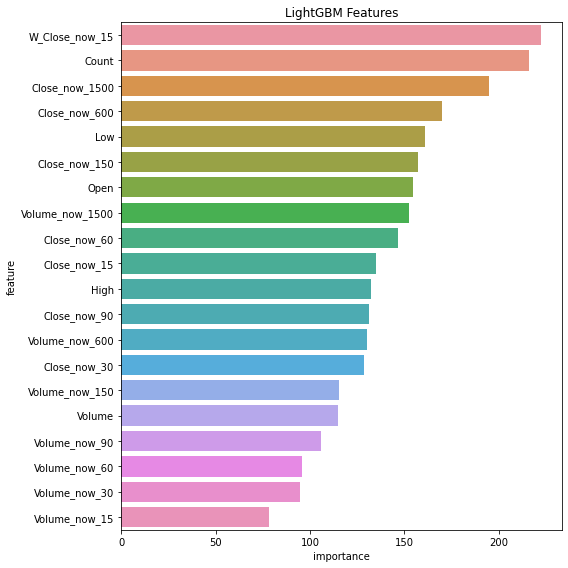

In [29]:
def print_gbm_model_feature_importance(model):
    feature_names = features
    try:
        importances = list(model.feature_importances_)
    except:
        importances = list(model.feature_importance())
    feature_importances = [(feature,round(importance)) for feature,importance in zip(feature_names,importances)]
    feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse=True)
    #print(feature_importances)
    return feature_importances
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = []
for model in modellist:
    feature_importance_df_ = print_gbm_model_feature_importance(model)
    feature_importance_df_ = pd.DataFrame(feature_importance_df_)
    feature_importance_df_.columns = ["feature", "importance"]
    feature_importance_df.append(feature_importance_df_)
feature_importance_df = pd.concat(feature_importance_df)
feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()

sss = feature_importance_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="importance", y="feature", 
            data=sss)
plt.title('LightGBM Features')
plt.tight_layout()

In [30]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import pickle
modellist_cat = []

# oof_predictions = np.zeros(df_train.shape[0])
test_predictions_cat = np.zeros((df_test.shape[0],len(enumeratelist)))

for fold, (trn_ind, val_ind) in enumerate(enumeratelist):
# for fold in range(4):
    print(f'Training fold {fold + 1}')
#     x_train, x_val = df_train[features].iloc[trn_ind], df_train[features].iloc[val_ind]
#     y_train, y_val = df_train[target].iloc[trn_ind], df_train[target].iloc[val_ind]
    x_test, y_test = df_test[features], df_test[target]


    saving_path_name = f"{modelpath}/cat_fold{fold}.pkl"
    model = CatBoostRegressor(iterations=100, learning_rate=0.05, depth=10, random_seed=42, verbose = 1)

    model.fit(df_train[features].iloc[trn_ind+val_ind], df_train[target].iloc[trn_ind+val_ind])

    pickle.dump(model, open(saving_path_name, "wb"))


    modellist_cat.append(model)
    test_predictions_cat[:,fold] = model.predict(x_test)







Training fold 1
0:	learn: 0.0054406	total: 1.52s	remaining: 2m 30s
1:	learn: 0.0054398	total: 2.9s	remaining: 2m 22s
2:	learn: 0.0054388	total: 4.24s	remaining: 2m 17s
3:	learn: 0.0054380	total: 5.58s	remaining: 2m 14s
4:	learn: 0.0054371	total: 6.96s	remaining: 2m 12s
5:	learn: 0.0054362	total: 8.29s	remaining: 2m 9s
6:	learn: 0.0054355	total: 9.63s	remaining: 2m 7s
7:	learn: 0.0054347	total: 11s	remaining: 2m 6s
8:	learn: 0.0054341	total: 12.3s	remaining: 2m 4s
9:	learn: 0.0054334	total: 13.6s	remaining: 2m 2s
10:	learn: 0.0054327	total: 15s	remaining: 2m 1s
11:	learn: 0.0054318	total: 16.4s	remaining: 2m
12:	learn: 0.0054311	total: 17.7s	remaining: 1m 58s
13:	learn: 0.0054305	total: 19.1s	remaining: 1m 57s
14:	learn: 0.0054297	total: 20.4s	remaining: 1m 55s
15:	learn: 0.0054290	total: 21.8s	remaining: 1m 54s
16:	learn: 0.0054284	total: 23.2s	remaining: 1m 53s
17:	learn: 0.0054276	total: 24.5s	remaining: 1m 51s
18:	learn: 0.0054271	total: 25.9s	remaining: 1m 50s
19:	learn: 0.0054264	

KeyboardInterrupt: 

In [ ]:
for ii in range(len(enumeratelist)):
    score_fold_test = pearsonr(df_test[target], test_predictions_cat[:,ii])[0]
    print(f'fold{ii} test corr is {score_fold_test}')
score_fold_test = pearsonr(df_test[target], np.mean(test_predictions_cat,axis=1))[0]
print(f'test corr mean is {score_fold_test}')


In [ ]:
np.corrcoef([np.mean(test_predictions,axis=1),np.mean(test_predictions_cat,axis=1)])

In [ ]:
comb = np.mean(test_predictions,axis=1)*0.5+np.mean(test_predictions_cat,axis=1)*0.5
score_fold_test = pearsonr(df_test[target], comb)[0]
print(f'test corr mean is {score_fold_test}')